In [78]:
import pandas as pd
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
import numpy as np
import collections

* Remove documents with only one tag.
* 

In [2]:
df = pd.read_csv("clean_data_clipped.csv")
df = df.fillna(-1)
df.head(7)


,Unnamed: 0,id,title,createdAt,updatedAt,content,topics,splitted
0,0,234912453,是要繼續還是不繼續,2020-12-03T07:20:36.671Z,2020-12-03T07:20:36.671Z,當初在一起都知道作息\n因為我都滿晚睡\n他因為要早起工作（天微亮那種\n所以作息是9.前就...,['感情'],"['當初', '在', '一起', '都', '知道', '作息', '因為', '我', ..."
1,1,234912409,懷孕禁忌,2020-12-03T07:09:46.706Z,2020-12-03T07:09:46.706Z,請問大家～懷孕中能去「台北霞海城隍廟」拜拜嗎？\n最近與老公婚姻出點狀況，想去祈求平安順利！...,"['結婚', '感情', '月老']","['請問', '大家', '～', '懷孕', '中', '能', '去', '「', '台..."
2,2,234912393,我對妳的愛可能這輩子無法再給別人了,2020-12-03T07:07:36.094Z,2020-12-03T07:07:36.094Z,"我把第三任稱A，第四任稱B,大三時期我跟A在12月6號相遇的，之後我們交往快兩年，但我們最後...",['感情'],"['我', '把', '第三', '任', '稱', 'A', '第四', '任', '稱'..."
3,3,234912379,關於縫紉這件事👫🏻,2020-12-03T07:04:30.777Z,2020-12-03T07:04:30.777Z,請問各位\n男友會替妳縫紉🧵東西嗎？\n例如：御守或是衣服等等...\n\n👇🏻以下是男友未...,['禮物'],"['請問', '各', '位', '男友', '會', '替', '妳', '縫紉', '🧵..."
4,4,234912282,年紀,2020-12-03T06:45:26.917Z,2020-12-03T06:45:26.917Z,女生會和比她年紀還小的男生交往？？,"['在一起', '閃光', '感情']","['女生', '會', '和', '比', '她', '年紀', '還', '小', '的'..."
5,5,234912279,對對方沒興趣了要如何結束曖昧呢？,2020-12-03T06:45:19.208Z,2020-12-03T06:45:19.208Z,我跟曖昧對象認識了兩個多月，是之前跟朋友去酒吧他來請我幫他和他朋友拍照，然後就認識了，交換I...,"['曖昧', '感情']","['我', '跟', '曖昧', '對象', '認識', '了', '兩', '個', '多..."
6,6,234912275,女友想從軍，招募員的方式很奇怪,2020-12-03T06:44:31.802Z,2020-12-03T06:44:31.802Z,事情是這樣子的，女友她從小就很想當警察，但因為身高不夠高不能報考而作罷，後來知道了海巡軍人跟...,['感情'],"['事情', '是', '這樣子', '的', '女友', '她', '從小', '就', ..."


In [4]:
document_list = []
topics = []
row_selected = []
for i in range(len(df.splitted.values)):
    df['splitted'][i] = df['splitted'][i].replace("\'", '\"')
#     df['splitted'][i][2:-3] = df['splitted'][i].replace("\"", '\'')
#     print(df['splitted'][i])
    try:
#         print(i, " ".join(json.loads(df['splitted'][i])))
        document_list.append(" ".join(json.loads(df['splitted'][i])))
        
        if df.topics[i] != -1:
            topics.append(np.array(json.loads(str(df.topics[i]).replace("\'", '\"'))))
        else:
            topics.append(np.array(["others"]))
        row_selected.append(True)
    except:
        row_selected.append(False)
        continue
print(len(document_list), len(topics))

80967 80967


In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", ngram_range=(2,4), max_features=3000)
X = vectorizer.fit_transform(document_list)

In [77]:
print(X.shape)

(80967, 3000)


In [6]:
def to_list(s):
    if type(s) == int:
        print(s)
        return ['others']
    s = s.replace("\'", '\"')
    s = json.loads(s)
    return s

## Data preparation & Exploration

In [7]:
df['topics'] = df['topics'].apply(to_list)

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


In [8]:
df['topics']

0                         [感情]
1                 [結婚, 感情, 月老]
2                         [感情]
3                         [禮物]
4                [在一起, 閃光, 感情]
                 ...          
82074    [遠距離, 分手, 失戀, 前任, 感情]
82075                     [感情]
82076             [分手, 感情, 前任]
82077                 [分手, 失戀]
82078                    [遠距離]
Name: topics, Length: 82079, dtype: object

In [9]:
pd.DataFrame.from_records(df['topics'].apply(collections.Counter)).fillna(0).describe()

,感情,結婚,月老,禮物,在一起,閃光,曖昧,價值觀,分手,復合,...,遠距離,約會,男生女生,單身,告白,暗戀,友情,搭訕,情人節,others
count,82079.000000,82079.000000,82079.000000,82079.000000,82079.000000,82079.000000,82079.00000,82079.000000,82079.000000,82079.000000,...,82079.000000,82079.000000,82079.000000,82079.000000,82079.000000,82079.000000,82079.000000,82079.000000,82079.000000,82079.000000
mean,0.812144,0.016643,0.015168,0.009479,0.067057,0.154144,0.09062,0.221323,0.228219,0.007907,...,0.103023,0.012464,0.023209,0.041070,0.035125,0.052352,0.022478,0.007407,0.006640,0.000305
std,0.390599,0.127929,0.122223,0.096897,0.250123,0.361089,0.28707,0.415140,0.419687,0.088570,...,0.303990,0.110943,0.150569,0.198454,0.184096,0.222737,0.148234,0.085748,0.081215,0.017450
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
pd.DataFrame.from_records(df['topics'].apply(collections.Counter)).fillna(0).corr()

,感情,結婚,月老,禮物,在一起,閃光,曖昧,價值觀,分手,復合,...,遠距離,約會,男生女生,單身,告白,暗戀,友情,搭訕,情人節,others
感情,1.000000,-0.000339,-0.034738,-0.049525,0.042894,-0.018940,0.009156,0.042421,-0.050694,-0.021864,...,-0.015544,-0.019350,-0.021987,-0.021178,0.002133,-0.029378,-0.000296,-0.039935,-0.036340,-0.036293
結婚,-0.000339,1.000000,-0.007574,-0.005846,-0.007463,-0.000675,-0.035427,0.065536,-0.027400,-0.011614,...,-0.015893,0.005129,0.000187,-0.014926,-0.018096,-0.029294,-0.016515,-0.009017,-0.007118,-0.002271
月老,-0.034738,-0.007574,1.000000,-0.008025,0.069151,-0.023164,-0.012786,-0.054879,-0.037084,0.075582,...,-0.030582,-0.003160,-0.016482,0.053679,-0.001478,0.003501,-0.010750,0.016017,0.009492,-0.002166
禮物,-0.049525,-0.005846,-0.008025,1.000000,-0.009134,0.065143,-0.020806,-0.025196,-0.039413,-0.008733,...,-0.000476,0.013944,0.007468,-0.010741,-0.009102,-0.016218,-0.005503,-0.006984,0.134436,-0.001708
在一起,0.042894,-0.007463,0.069151,-0.009134,1.000000,0.050127,0.077413,-0.003891,-0.103542,-0.019535,...,-0.022279,0.044959,-0.006387,0.114121,0.111836,0.006310,-0.003194,0.040463,-0.000328,-0.004680
閃光,-0.018940,-0.000675,-0.023164,0.065143,0.050127,1.000000,-0.098087,-0.004160,-0.149410,-0.032777,...,0.031917,0.024121,-0.030621,-0.065733,-0.036912,-0.093520,-0.042655,-0.025860,0.026170,-0.007451
曖昧,0.009156,-0.035427,-0.012786,-0.020806,0.077413,-0.098087,1.000000,-0.060134,-0.138491,-0.027223,...,-0.037735,0.029569,0.017862,0.016792,0.141952,0.120920,0.048904,0.005891,-0.015357,-0.005510
價值觀,0.042421,0.065536,-0.054879,-0.025196,-0.003891,-0.004160,-0.060134,1.000000,-0.013904,-0.033016,...,-0.031232,-0.008839,0.007286,-0.022342,-0.065373,-0.096584,-0.009967,-0.025520,-0.027688,-0.009306
分手,-0.050694,-0.027400,-0.037084,-0.039413,-0.103542,-0.149410,-0.138491,-0.013904,1.000000,0.088787,...,0.025037,-0.053764,-0.058951,-0.060316,-0.088930,-0.121556,-0.063856,-0.045284,-0.026587,-0.009492
復合,-0.021864,-0.011614,0.075582,-0.008733,-0.019535,-0.032777,-0.027223,-0.033016,0.088787,1.000000,...,-0.009893,-0.008790,-0.011934,-0.017089,-0.014792,-0.020983,-0.012610,-0.007712,-0.003911,-0.001558


In [12]:
y_label_columns = pd.DataFrame.from_records(df['topics'].apply(collections.Counter)).fillna(0).columns

In [14]:
y = pd.DataFrame.from_records(df['topics'][row_selected].apply(collections.Counter)).fillna(0).values

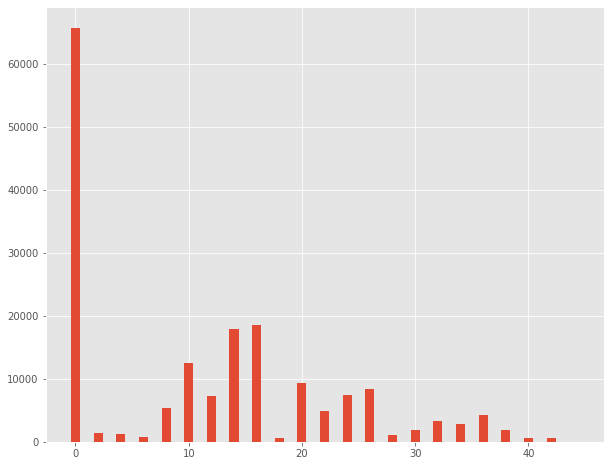

In [15]:
plt.figure(figsize=(10,8))
plt.bar(np.arange(23)*2, np.sum(y, axis=0), 0.8, label=y_label_columns)
plt.show()

## Multioutput Model testing

In [35]:
X.shape

(80967, 24662834)

In [156]:
forest = RandomForestClassifier(random_state=1, n_estimators=500, max_depth=5, min_samples_leaf=4, min_samples_split=8, verbose=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [158]:
x_train.sort_indices()

In [159]:
multi_target_forest.fit(x_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=5,
                                                       min_samples_leaf=4,
                                                       min_samples_split=8,
                                                       n_estimators=500,
                                                       random_state=1,
                                                       verbose=1),
                      n_jobs=-1)

In [147]:
sum(abs(y_pred[:, 2]))

0.0

In [160]:
y_pred = multi_target_forest.predict(x_train)
precision_mean = 0
recall_mean = 0
for i in range(23):
    tn, fp, fn, tp = confusion_matrix(y_pred[:, i], y_train[:, i]).ravel()
    if tp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    acc = (tp + tn) / (tp + tn + fp + fn)
    precision_mean += precision
    recall_mean += recall
    print(f"class:{y_label_columns[i]}  \t precision:{precision:.4f} recall: {recall:.4f} acc: {acc:.4f} \t tn:{tn} tp:{tp} fp:{fp} fn:{fn}" )
precision_mean /= 23.0
recall_mean /= 23.0
print(f"overall precision {precision_mean:.4f} recall: {recall_mean:.4f}")
    

class:感情  	 precision:1.0000 recall: 0.8118 acc: 0.8118 	 tn:0 tp:52580 fp:0 fn:12193
class:結婚  	 precision:0.0000 recall: nan acc: 0.9834 	 tn:63697 tp:0 fp:1076 fn:0
class:月老  	 precision:0.0000 recall: nan acc: 0.9848 	 tn:63789 tp:0 fp:984 fn:0
class:禮物  	 precision:0.0000 recall: nan acc: 0.9906 	 tn:64163 tp:0 fp:610 fn:0
class:在一起  	 precision:0.0000 recall: nan acc: 0.9326 	 tn:60405 tp:0 fp:4368 fn:0
class:閃光  	 precision:0.0000 recall: nan acc: 0.8458 	 tn:54784 tp:0 fp:9989 fn:0


<ipython-input-160-fedc5994242b>:10: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)


class:曖昧  	 precision:0.0000 recall: nan acc: 0.9085 	 tn:58847 tp:0 fp:5926 fn:0
class:價值觀  	 precision:0.0000 recall: nan acc: 0.7802 	 tn:50538 tp:0 fp:14235 fn:0
class:分手  	 precision:0.0000 recall: nan acc: 0.7717 	 tn:49988 tp:0 fp:14785 fn:0
class:復合  	 precision:0.0000 recall: nan acc: 0.9919 	 tn:64251 tp:0 fp:522 fn:0
class:失戀  	 precision:0.0000 recall: nan acc: 0.8844 	 tn:57286 tp:0 fp:7487 fn:0
class:劈腿  	 precision:0.0000 recall: nan acc: 0.9385 	 tn:60787 tp:0 fp:3986 fn:0
class:前任  	 precision:0.0000 recall: nan acc: 0.9089 	 tn:58871 tp:0 fp:5902 fn:0
class:遠距離  	 precision:0.0000 recall: nan acc: 0.8979 	 tn:58161 tp:0 fp:6612 fn:0
class:約會  	 precision:0.0000 recall: nan acc: 0.9875 	 tn:63966 tp:0 fp:807 fn:0
class:男生女生  	 precision:0.0000 recall: nan acc: 0.9765 	 tn:63252 tp:0 fp:1521 fn:0
class:單身  	 precision:0.0000 recall: nan acc: 0.9587 	 tn:62096 tp:0 fp:2677 fn:0
class:告白  	 precision:0.0000 recall: nan acc: 0.9643 	 tn:62459 tp:0 fp:2314 fn:0
class:暗戀  	 

In [161]:
x_test.sort_indices()
y_pred = multi_target_forest.predict(x_test)
for i in range(23):
    tn, fp, fn, tp = confusion_matrix(y_pred[:, i], y_test[:, i]).ravel()
    if tp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    acc = (tp + tn) / (tp + tn + fp + fn)
    precision_mean += precision
    recall_mean += recall
    print(f"class:{y_label_columns[i]}  \t precision:{precision:.4f} recall: {recall:.4f} acc: {acc:.4f} \t tn:{tn} tp:{tp} fp:{fp} fn:{fn}" )
precision_mean /= 23.0
recall_mean /= 23.0
print(f"overall precision {precision_mean:.4f} recall: {recall_mean:.4f}")
    

class:感情  	 precision:1.0000 recall: 0.8140 acc: 0.8140 	 tn:0 tp:13182 fp:0 fn:3012
class:結婚  	 precision:0.0000 recall: nan acc: 0.9842 	 tn:15938 tp:0 fp:256 fn:0
class:月老  	 precision:0.0000 recall: nan acc: 0.9849 	 tn:15949 tp:0 fp:245 fn:0
class:禮物  	 precision:0.0000 recall: nan acc: 0.9900 	 tn:16032 tp:0 fp:162 fn:0
class:在一起  	 precision:0.0000 recall: nan acc: 0.9351 	 tn:15143 tp:0 fp:1051 fn:0
class:閃光  	 precision:0.0000 recall: nan acc: 0.8458 	 tn:13697 tp:0 fp:2497 fn:0
class:曖昧  	 precision:0.0000 recall: nan acc: 0.9128 	 tn:14782 tp:0 fp:1412 fn:0
class:價值觀  	 precision:0.0000 recall: nan acc: 0.7755 	 tn:12559 tp:0 fp:3635 fn:0
class:分手  	 precision:0.0000 recall: nan acc: 0.7713 	 tn:12490 tp:0 fp:3704 fn:0
class:復合  	 precision:0.0000 recall: nan acc: 0.9925 	 tn:16073 tp:0 fp:121 fn:0
class:失戀  	 precision:0.0000 recall: nan acc: 0.8851 	 tn:14334 tp:0 fp:1860 fn:0
class:劈腿  	 precision:0.0000 recall: nan acc: 0.9422 	 tn:15258 tp:0 fp:936 fn:0
class:前任  	 prec

<ipython-input-161-e1cffe682773>:9: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)


In [95]:
for i in range(23):
    tn, fp, fn, tp = confusion_matrix(y_pred[:, i], y_test[:, i]).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    acc = (tp + tn) / (tp + tn + fp + fn)
    print(f"class:{y_label_columns[i]}  \t precision:{precision:.4f} recall: {recall:.4f} acc: {acc:.4f} \t tn:{tn} tp:{tp} fp:{fp} fn:{fn}" )
    

class:感情  	 precision:0.9992 recall: 0.8143 acc: 0.8139 	 tn:9 tp:13171 fp:11 fn:3003
class:結婚  	 precision:0.0078 recall: 1.0000 acc: 0.9843 	 tn:15938 tp:2 fp:254 fn:0
class:月老  	 precision:0.5469 recall: 0.8375 acc: 0.9915 	 tn:15923 tp:134 fp:111 fn:26
class:禮物  	 precision:0.0000 recall: nan acc: 0.9900 	 tn:16032 tp:0 fp:162 fn:0
class:在一起  	 precision:0.0057 recall: 0.8571 acc: 0.9354 	 tn:15142 tp:6 fp:1045 fn:1
class:閃光  	 precision:0.0120 recall: 0.6122 acc: 0.8465 	 tn:13678 tp:30 fp:2467 fn:19
class:曖昧  	 precision:0.0269 recall: 0.8261 acc: 0.9147 	 tn:14774 tp:38 fp:1374 fn:8
class:價值觀  	 precision:0.0259 recall: 0.7121 acc: 0.7790 	 tn:12521 tp:94 fp:3541 fn:38
class:分手  	 precision:0.3213 recall: 0.7981 acc: 0.8262 	 tn:12189 tp:1190 fp:2514 fn:301
class:復合  	 precision:0.0083 recall: 1.0000 acc: 0.9926 	 tn:16073 tp:1 fp:120 fn:0
class:失戀  	 precision:0.0059 recall: 0.6875 acc: 0.8855 	 tn:14329 tp:11 fp:1849 fn:5
class:劈腿  	 precision:0.0171 recall: 0.6400 acc: 0.9426

<ipython-input-95-0b70efaaccdb>:4: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)


In [76]:
y_pred[263]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

## Single output model testing

In [88]:
X.shape

(80967, 3000)

In [89]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
x_train.sort_indices()
x_test.sort_indices()

In [114]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0, n_jobs=-1)
clf.fit(x_train, y_train[:, 1])

RandomForestClassifier(max_depth=2, n_estimators=1000, n_jobs=-1,
                       random_state=0)

In [115]:
y_pred = clf.predict_proba(x_test) > 0.01
tn, fp, fn, tp = confusion_matrix(y_test[:, 1], y_pred[:, 1]).ravel()

In [116]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
acc = (tp + tn) / (tp + tn + fp + fn)
print(f"precision:{precision:.4f} recall: {recall:.4f} acc: {acc:.4f} \t tn:{tn} tp:{tp} fp:{fp} fn:{fn}" )

precision:0.0158 recall: 1.0000 acc: 0.0158 	 tn:0 tp:256 fp:15938 fn:0


In [117]:
sum(y_test[:, 0]), len(y_test[:, 0])

(13182.0, 16194)

## Try feature selection

In [42]:
from sklearn.feature_selection import chi2

In [44]:
chi2_feature_importance, chi2_p_value = chi2(X, y)

In [61]:
np.sum(chi2_p_value < 0.1)

2346

In [53]:
X[:, (chi2_p_value < 0.1)]

<80967x1042 sparse matrix of type '<class 'numpy.float64'>'
	with 1084559 stored elements in Compressed Sparse Row format>

In [62]:
x_train, x_test, y_train, y_test = train_test_split(X[:, (chi2_p_value < 0.1)], y, test_size=0.2, random_state=42)

In [63]:
x_train.sort_indices()
x_test.sort_indices()

In [67]:
clf = RandomForestClassifier(n_estimators=500, max_depth=4, random_state=0, n_jobs=-1)
clf.fit(x_train, y_train[:, 1])

RandomForestClassifier(max_depth=4, n_estimators=500, random_state=0)

In [68]:
y_pred = clf.predict(x_test)
tn, fp, fn, tp = confusion_matrix(y_test[:, 1], y_pred).ravel()

In [69]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
acc = (tp + tn) / (tp + tn + fp + fn)
print(f"precision:{precision:.4f} recall: {recall:.4f} acc: {acc:.4f} \t tn:{tn} tp:{tp} fp:{fp} fn:{fn}" )

precision:nan recall: 0.0000 acc: 0.9842 	 tn:15938 tp:0 fp:0 fn:256


<ipython-input-69-f2dfbafc92d4>:1: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


## Classifier chain

In [118]:
clf = RandomForestClassifier(n_estimators=500, max_depth=4, random_state=0, n_jobs=-1)
chain = ClassifierChain(clf, order='random', random_state=0)

In [119]:
x_train.sort_indices()
x_test.sort_indices()

In [121]:
y_pred = chain.fit(x_train, y_train).predict_proba(x_test)

In [123]:
for i in range(23):
    tn, fp, fn, tp = confusion_matrix(y_test[:, i], y_pred[:, i]> 0.05).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    acc = (tp + tn) / (tp + tn + fp + fn)
    print(f"class:{y_label_columns[i]}  \t precision:{precision:.4f} recall: {recall:.4f} acc: {acc:.4f} \t tn:{tn} tp:{tp} fp:{fp} fn:{fn}" )

class:感情  	 precision:0.8140 recall: 1.0000 acc: 0.8140 	 tn:0 tp:13182 fp:3012 fn:0
class:結婚  	 precision:0.7273 recall: 0.0312 acc: 0.9845 	 tn:15935 tp:8 fp:3 fn:248
class:月老  	 precision:0.7891 recall: 0.4735 acc: 0.9901 	 tn:15918 tp:116 fp:31 fn:129
class:禮物  	 precision:0.5714 recall: 0.0247 acc: 0.9901 	 tn:16029 tp:4 fp:3 fn:158
class:在一起  	 precision:0.0649 recall: 1.0000 acc: 0.0649 	 tn:0 tp:1051 fp:15143 fn:0
class:閃光  	 precision:0.1542 recall: 1.0000 acc: 0.1542 	 tn:0 tp:2497 fp:13697 fn:0
class:曖昧  	 precision:0.0872 recall: 1.0000 acc: 0.0872 	 tn:0 tp:1412 fp:14782 fn:0
class:價值觀  	 precision:0.2245 recall: 1.0000 acc: 0.2245 	 tn:0 tp:3635 fp:12559 fn:0
class:分手  	 precision:0.2287 recall: 1.0000 acc: 0.2287 	 tn:0 tp:3704 fp:12490 fn:0
class:復合  	 precision:0.0000 recall: 0.0000 acc: 0.9925 	 tn:16072 tp:0 fp:1 fn:121
class:失戀  	 precision:0.1149 recall: 1.0000 acc: 0.1149 	 tn:0 tp:1860 fp:14334 fn:0
class:劈腿  	 precision:0.0578 recall: 1.0000 acc: 0.0578 	 tn:0 t

<ipython-input-123-f0e6a82b8ffe>:3: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


class:友情  	 precision:0.7500 recall: 0.0081 acc: 0.9773 	 tn:15823 tp:3 fp:1 fn:367
class:搭訕  	 precision:1.0000 recall: 0.0085 acc: 0.9928 	 tn:16076 tp:1 fp:0 fn:117
class:情人節  	 precision:nan recall: 0.0000 acc: 0.9937 	 tn:16092 tp:0 fp:0 fn:102
class:others  	 precision:nan recall: 0.0000 acc: 0.9998 	 tn:16190 tp:0 fp:0 fn:4
